# Introduction

1. I might be doing the scalar multiplies with the transpose -- if things don't work, check here
2. Check the actor loss -- am I screwing things up with the tranposing?

3. Implement prioritized experience replay.


### Test on cartpole

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
(episode, score) = (50, 66.0)
probs = [[0.5030391  0.49696085]]
probs = [[0.49951744 0.50048256]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
probs = [[nan nan]]
prob

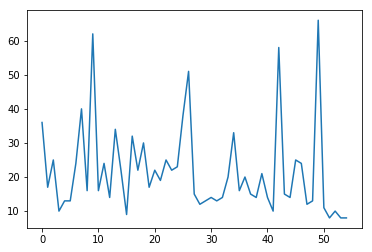

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from agent import Agent
%matplotlib inline


#Environment
env = gym.make('CartPole-v0')
env.seed(0)
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n


#Agent
lr,gamma,tau = 3*10**-4, 0.99, 0.01, 
clipnorm, clipnorm_val, verbose, alpha = True, 0.001, False, 0.001
agent = Agent(input_dim, output_dim, lr, gamma, tau, alpha, clipnorm, clipnorm_val, verbose)
agent.memory_size = 10000
agent.batchsize = 32


#Train
EPISODES = 55
scores = []
for e in range(1,EPISODES+1):
    state = env.reset()
    state = agent.make_tensor(state)
    reward_sum = 0
    done = False
    while not done:
        
        #Do main step
        # env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward_sum += reward
        next_state = agent.make_tensor(next_state)
        agent.remember(state[0],action,reward,next_state[0],done) #want to remember state as a vec
        state = next_state

        #Learn
        if e > 50:
            agent.learn()
            print 'probs = ' + str(agent.actor.model.predict(state))

    
    #Print results
    scores.append(reward_sum)
    if e % 50 == 0:
        print '(episode, score) = ' + str((e,reward_sum))
plt.plot(scores)

### Change actor network

In [15]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Input, concatenate
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras.utils import to_categorical

clipnorm = True

#Inputs
S_pl = agent.actor.model.input
A_pl = K.placeholder(shape=(None, agent.output_dim))  #onehot
Q_pl = K.placeholder(shape=(None,1))
V_pl = K.placeholder(shape=(None,1))

#Find terms in bracket
pi_vec = agent.actor.model.output
pi = K.sum(pi_vec*A_pl,axis=1)    # get \pi(s_t, a_t) -- prob for specific action
entropy = agent.alpha*K.log(pi)
temp = entropy - K.transpose(Q_pl) + K.transpose(V_pl)  #this is a row vec
temp = K.transpose(temp)      #turn it into col vec

#Find grad log(pi)
pi_pl = agent.actor.model.output
pars = agent.actor.model.trainable_weights
grads = tf.gradients( K.log(pi_pl), pars)   #scalar multiply by temp

#Clip gradients
if agent.actor.clipnorm == True:
    grads = tf.clip_by_global_norm(grads, 0.1)[0]
    
opt = Adam(lr=lr)
loss = grads  #placeholder, I won't use it
updates = opt.get_updates(loss = grads, params = pars, grads = grads)
weights = [weight for weight in agent.actor.model.weights]
func = K.function(inputs = [S_pl, A_pl, Q_pl, V_pl], outputs = weights, updates = updates)



S,A,R,S1,D = agent.get_batch()
Q = agent.criticQ.model.predict([S,A])
V_target = agent.criticV.target_model.predict(S1)  #value of NEXT state


grads1 = func([S,A,Q,V_target])
[grad.max() for grad in grads1]

[0.15364876, 0.0038149743, 0.11200529, 0.003815397, 0.1562366, 0.0038159895]